<h1>Logistic Regression: 3 Classes<h1>
<h3>Load in data and import modules<h3>

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('full_mag_insulators.csv')

In [3]:
# Drop rows with missing values in features or target
df = df.dropna(subset=['ordering'])

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


<h4>Create model and validate using 3 classes.<h4>

In [5]:
# Separate features and target
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
extra_cols = ['is_gap_direct', 'is_stable']
#['symmetry', 'elements', 'chemsys', 'formula', 'composition', 'structure']
categorical_cols = ['symmetry', 'elements', 'chemsys']

# Prepare X
X = df[numerical_columns + extra_cols + categorical_cols]

# Merge FM and FiM into one class, then define y
df["ordering"] = df["ordering"].replace({"FM": "FM_FiM", "FiM": "FM_FiM"})
y = df['ordering']

# Split first into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Frequency encode high-cardinality categorical columns
for col in categorical_cols:
    freq = X_train[col].value_counts()
    X_train[col + '_freq'] = X_train[col].map(freq)
    X_val[col + '_freq'] = X_val[col].map(freq).fillna(0)

# Drop original high-cardinality columns
X_train = X_train.drop(columns=categorical_cols)
X_val = X_val.drop(columns=categorical_cols)

# One-hot encode the last two columns
X_train = pd.get_dummies(X_train, columns=extra_cols)
X_val = pd.get_dummies(X_val, columns=extra_cols)

# Align columns
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42))
])

scores = cross_val_score(pipe, X_train, y_train, cv=4, scoring='accuracy')
print(f"Cross-validated accuracy scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f}")

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\s

Cross-validated accuracy scores: [0.62049957 0.61447028 0.61739879 0.60981912]
Mean accuracy: 0.616


In [6]:
# Fit on full training set and evaluate on validation set
pipe.fit(X_train, y_train)
test_accuracy = pipe.score(X_val, y_val)
print(f"Test set accuracy: {test_accuracy:.3f}")

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test set accuracy: 0.626


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

         AFM       0.07      0.58      0.12       171
      FM_FiM       0.71      0.50      0.59      3402
          NM       0.78      0.73      0.75      4168

    accuracy                           0.63      7741
   macro avg       0.52      0.60      0.49      7741
weighted avg       0.74      0.63      0.67      7741



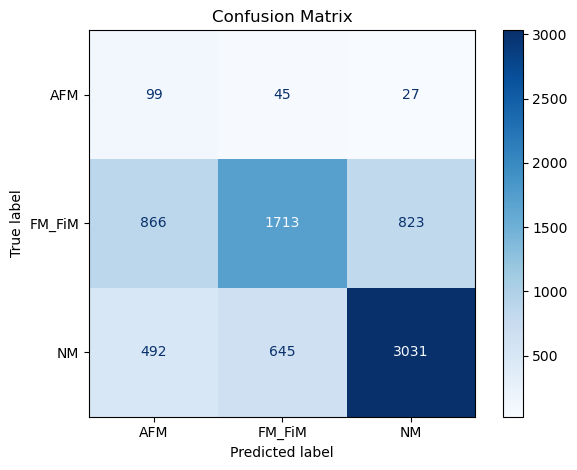

In [8]:
# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

# Predict on the validation set
y_pred = pipe.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=pipe.named_steps['clf'].classes_))

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=pipe.named_steps['clf'].classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.named_steps['clf'].classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

c:\Users\dovak\Anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


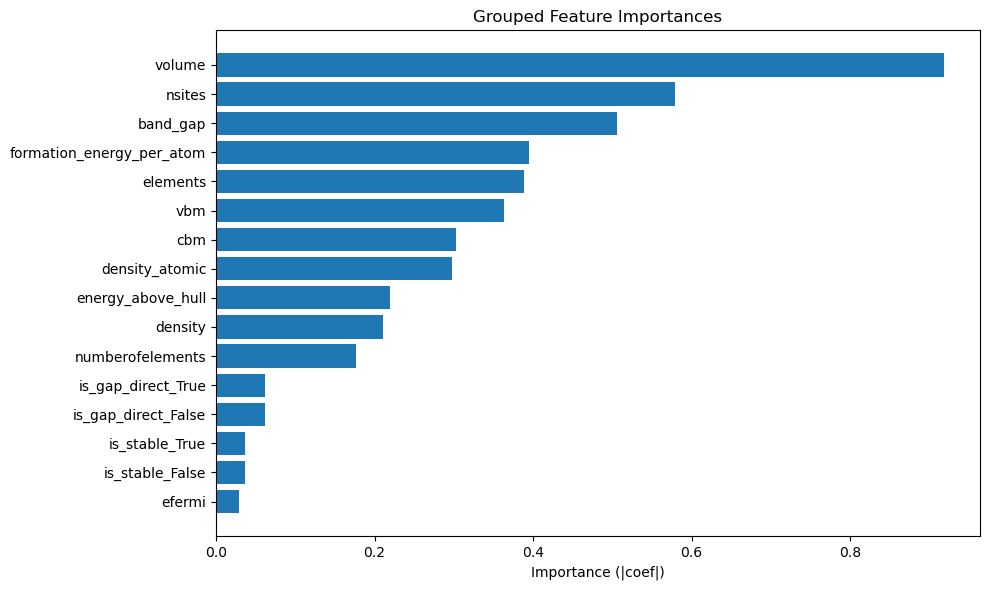

In [9]:
pipe.fit(X_train, y_train)

# For multinomial, take mean absolute value across classes
coefs = np.abs(pipe.named_steps['clf'].coef_).mean(axis=0)
feat_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": coefs
})

numerical_features = numerical_columns
# Add one-hot encoded columns for is_stable and is_gap_direct
onehot_cols = [col for col in X_train.columns if col.startswith('is_stable') or col.startswith('is_gap_direct')]
numerical_features += onehot_cols
numerical_df = feat_df[feat_df["feature"].isin(numerical_features)]
element_importance = feat_df[~feat_df["feature"].isin(numerical_features)]["importance"].sum()

grouped_df = pd.concat([
    numerical_df,
    pd.DataFrame([{"feature": "elements", "importance": element_importance}])
], ignore_index=True)

grouped_df = grouped_df.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(grouped_df["feature"], grouped_df["importance"])
plt.xlabel("Importance (|coef|)")
plt.title("Grouped Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
AFM_count = np.sum(y_val == 'AFM')
print(AFM_count)

683
